## homework 3 - introduction to graph networks

goals of this assignment:
1. basic introduction to the DGL library https://www.dgl.ai/
2. train a classifier that takes a point cloud as input. to submit you must achieve validation accuracy over 85%
3. learn to work with dgl graphs, node data and batching
4. build a deepset architecture with dgl mean_nodes and broadcast_nodes functions




first step, download the dataset. 
its a modified version of the MNIST dataset where the images have been converted to point clouds

In [1]:
#!wget https://www.dropbox.com/s/3vuzm1mqwa08zvq/mnist_pointclouds.h5

--2021-05-31 15:16:39--  https://www.dropbox.com/s/246zhani5mptt7a/Dataset.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/246zhani5mptt7a/Dataset.zip [following]
--2021-05-31 15:16:39--  https://www.dropbox.com/s/raw/246zhani5mptt7a/Dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfee07274bbb3c331c00631ef1c.dl-eu.dropboxusercontent.com/cd/0/inline/BPgVHu01HWJJb3mVbcqDd-nF3wRhHn4nUrllCS9VKGrSBtm_fkYki5ScNU8izmXRlNe2JC2VkIcRd1qRn5o6urkODFTvLyzlHUUsoKeRqCczKTTU0YlK-EXeUcvxZri2AmQQq6P3X6fc6zUF-KVCb0_7/file# [following]
--2021-05-31 15:16:39--  https://ucfee07274bbb3c331c00631ef1c.dl-eu.dropboxusercontent.com/cd/0/inline/BPgVHu01HWJJb3mVbcqDd-nF3wRhHn4nUrllCS9VKGrSBtm_fkYki5ScNU8izmXRlNe2JC2VkIcRd1qRn5o6urk

In [4]:
##!pip install dgl
!pip install dgl-cu100

     |████████████████████████████████| 24.6MB 118kB/s 


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dgl
import torch

#### dataset object is already built - no need to deal with it - but its a good idea to have a look at how the DGL graph is created.

In [3]:
from dataloader import PointCloudMNISTdataset, collate_graphs

In [4]:
data = PointCloudMNISTdataset('mnist_pointclouds.h5')

N_train = int(len(data)*0.9)

training_dataset = torch.utils.data.Subset(data,range(N_train))
validation_dataset = torch.utils.data.Subset(data,range(N_train,len(data)))

the dataset returns a graph, and a target class (0 to 9)

In [5]:
g, y = training_dataset[31]

In [6]:
g,y

(Graph(num_nodes=175, num_edges=0,
       ndata_schemes={'xy': Scheme(shape=(2,), dtype=torch.float32)}
       edata_schemes={}),
 8)

the graphs have no edges, they are just a collection of nodes - 

and the nodes have a feature which is named "xy"

"xy" represnts the position of the node in 2d space

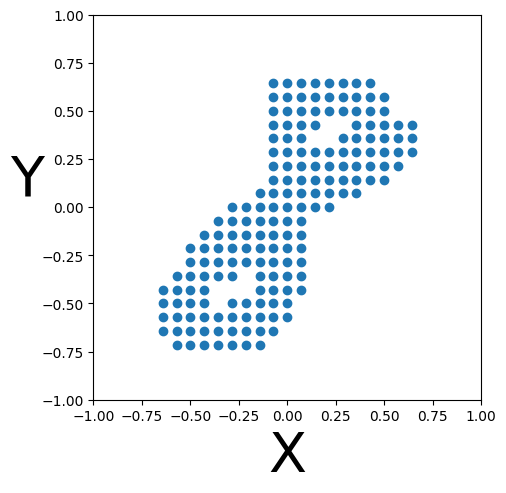

In [7]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(5,5))

xy = g.ndata['xy'].data.numpy()

ax.scatter( xy[:,0],xy[:,1] )

ax.set_ylabel('Y ',fontsize=40,rotation=0)
ax.set_xlabel('X',fontsize=40)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
plt.show()

###  dataloader and the custom collate function

since we need to batch our data in a "special" way, we have to tell the pytorch dataloader how to do it
we do this with the collate_graphs function which we define in dataloader.py

its already implemented, so you don't need to deal with it - but have a look at the code

In [8]:
from torch.utils.data import Dataset, DataLoader

data_loader = DataLoader(training_dataset, batch_size=100, shuffle=True,
                         collate_fn=collate_graphs, num_workers=0)
validation_data_loader = DataLoader(validation_dataset, batch_size=100, shuffle=False,
                         collate_fn=collate_graphs, num_workers=0)

In [9]:
for batched_g,y in data_loader:
    break

the batched graph includes all the nodes from all the graphs - and dgl keeps track of which nodes belong to each graph

In [10]:
batched_g,y

(Graph(num_nodes=15461, num_edges=0,
       ndata_schemes={'xy': Scheme(shape=(2,), dtype=torch.float32)}
       edata_schemes={}),
 tensor([8, 1, 5, 5, 7, 1, 9, 9, 8, 4, 1, 7, 7, 5, 0, 7, 1, 7, 7, 4, 3, 7, 0, 2,
         3, 2, 7, 6, 7, 1, 3, 9, 8, 0, 0, 8, 4, 6, 3, 9, 2, 6, 2, 3, 2, 7, 0, 5,
         6, 0, 9, 1, 7, 0, 6, 0, 8, 5, 2, 7, 3, 9, 5, 0, 9, 8, 4, 5, 3, 0, 2, 4,
         2, 1, 7, 7, 6, 6, 4, 4, 2, 8, 2, 8, 2, 7, 5, 5, 2, 6, 8, 8, 1, 8, 2, 2,
         5, 9, 1, 3]))

In [11]:
batched_g.batch_num_nodes()

tensor([209,  60, 118, 182, 100,  67, 148, 152, 184, 118,  92, 144, 143, 177,
        208, 155,  84, 116, 171, 174, 181, 104, 179, 143, 151,  99, 134, 214,
        153, 115, 142, 146, 161, 170, 209, 145, 149, 216, 172, 127, 161, 174,
        158, 239, 204,  96, 213, 195, 134, 174, 149, 114, 148, 195, 136, 181,
        158, 140, 250,  99, 120, 147,  85, 144, 128, 197, 146, 119, 142, 196,
        251, 100, 181,  84, 145, 126, 173, 143, 137, 118, 213, 165, 234, 178,
        160, 203, 117, 104, 223, 184, 186, 158,  78, 196, 222, 140, 168, 141,
         74, 205])

## Building the model

- the final model should take a graph as input, and return a vector of length 10 (remember this is MNIST and our task is to classify digits)
- below you can see 3 main NN components: **encoder**, **update block**, and **classifier**

![network.jpeg](./network.jpeg)

In [12]:
from model import Net

In [13]:
net = Net()

In [14]:
for batched_g,y in data_loader:
    break

make sure you are getting the right output shape.

In [15]:
net(batched_g).shape

/Users/ets/miniconda3/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


torch.Size([100, 10])

## you can submit the homework when the validation accuracy is above 80%

In [ ]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:0')

net.to(device)

In [17]:
import torch.nn as nn
import torch.optim as optim


loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005) 

In [18]:
def compute_accuracy_and_loss(dataloader,net):
    total = 0
    correct = 0
    
    loss = 0
    
    if torch.cuda.is_available():
        net.cuda()
    net.eval()
    
    n_batches = 0
    with torch.no_grad():
        for batched_g,y in dataloader:
            n_batches+=1

            if torch.cuda.is_available():
                batched_g = batched_g.to(torch.device('cuda'))
                y = y.cuda()
            pred = net(batched_g)         

            loss+= loss_func(pred,y).item()
            
            pred = torch.argmax(pred,dim=1)

            correct+=len(torch.where(pred==y)[0])
            total+=len(y)
    loss = loss/n_batches      
    return correct/total, loss

In [19]:
if torch.cuda.is_available():
    net.cuda()

In [20]:
from tqdm.notebook import tqdm

n_epochs = 5
bestacc  = -999

training_loss_vs_epoch = []
validation_loss_vs_epoch = []

training_acc_vs_epoch = []
validation_acc_vs_epoch = []

pbar = tqdm( range(n_epochs) )

for epoch in pbar:
    
    if len(validation_loss_vs_epoch) > 1:
        pbar.set_description('val acc:'+'{0:.5f}'.format(validation_acc_vs_epoch[-1])+', train acc:'+'{0:.5f}'.format(training_acc_vs_epoch[-1]))
       
    net.train() # put the net into "training mode"
    for batched_g,y in data_loader:
        if torch.cuda.is_available():
            batched_g = batched_g.to(torch.device('cuda'))
            y = y.cuda()
            
        optimizer.zero_grad()
        pred = net(batched_g)
        loss = loss_func(pred,y)
        loss.backward()
        optimizer.step()
    
    net.eval() #put the net into evaluation mode
    train_acc, train_loss = compute_accuracy_and_loss(data_loader,net)
    valid_acc, valid_loss =  compute_accuracy_and_loss(validation_data_loader,net)
         
    training_loss_vs_epoch.append(train_loss)    
    training_acc_vs_epoch.append( train_acc )
    
    validation_acc_vs_epoch.append(valid_acc)
    validation_loss_vs_epoch.append(valid_loss)

    #keep model with best accuracy
    if len(validation_loss_vs_epoch)==1 or validation_acc_vs_epoch[-1] > bestacc:
        torch.save(net.state_dict(), 'trained_model.pt')
        bestacc = validation_acc_vs_epoch[-1]

  0%|          | 0/5 [00:00<?, ?it/s]

In [21]:
print(bestacc)

0.9718333333333333


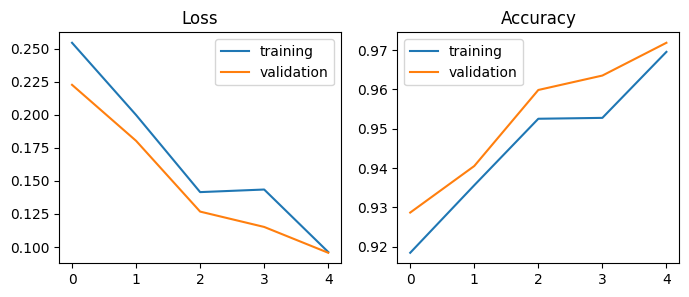

In [22]:
fig,ax = plt.subplots(1,2,figsize=(8,3))

ax[0].plot(training_loss_vs_epoch,label='training')
ax[0].plot(validation_loss_vs_epoch,label='validation')
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(training_acc_vs_epoch,label='training')
ax[1].plot(validation_acc_vs_epoch,label='validation')
ax[1].set_title('Accuracy')
ax[1].legend()

plt.show()